In [1]:
import os
import glob
import csv
import pprint as pp
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
from functools import reduce

import omop_analyze
import s4s_analyze

original_path = os.getcwd()

In [2]:
def omop_formatted(tables):
    return {filename: len(table) for filename, table in tables.items()}
    
def s4s_formatted(counts):
    return {k: len(v) for k, v in counts.items()}

def filter_matches(omop_tables, s4s_uniques):
    return filter_procedures(omop_tables, s4s_uniques)

def filter_procedures(omop_tables, s4s_uniques):
    return omop_tables, s4s_uniques

def csv_to_dicts(filename):
    with open(filename, encoding="utf8") as csv_file:
        items = (filename, list(csv.DictReader(csv_file, delimiter="\t")))
    return items

def fetch_at_path(resource, path):
    if type(path) == type(''):
        path = path.split('.')
    def walk(data, k):
        if isinstance(data, dict):
            return data.get(k)
        elif isinstance(data, list):
            return [reduce(walk, [k], el) for el in data]
        return None
    return reduce(walk, path, resource)

In [3]:
vocab = csv_to_dicts('VOCABULARY.csv')[1]
vocab_df = pd.DataFrame(vocab)
concept = csv_to_dicts('CONCEPT.csv')[1]
concept_df = pd.DataFrame(concept)
concept_cpt4 = csv_to_dicts('CONCEPT_CPT4.csv')[1]
cpt4_df = pd.DataFrame(concept_cpt4)
concept_aouppi = csv_to_dicts('CONCEPT_AOUPPI.csv')[1]
aouppi_df = pd.DataFrame(concept_aouppi)

In [4]:
concept_df.set_index(['concept_id',], inplace=True)
cpt4_df.set_index(['concept_id',], inplace=True)
aouppi_df.set_index(['concept_id',], inplace=True)
vocab_df.set_index(['vocabulary_id',], inplace=True)

CONCEPT_TABLES = [concept_df, cpt4_df, aouppi_df]

In [5]:
source_vocab_to_vocab_id = defaultdict(set)
#quick and dirty caching
def memoize(f):
    memo = {}
    def helper(x):
        if x not in memo:            
            memo[x] = f(x)
        return memo[x]
    return helper

missing_concept_codes = set()

@memoize
def omop_source_concept_code(concept_id):
    concept_code = None
    for table in CONCEPT_TABLES:
        try:
            concept_code = table.loc[concept_id].concept_code
            if concept_code:
                break
        except KeyError:
            continue
    else:
        missing_concept_codes.add(concept_id)
    return concept_code

@memoize
def omop_concept_vocabulary_id(concept_id):
    concept_tables = [concept_df, cpt4_df, aouppi_df]
    vocabulary_id = None
    for table in CONCEPT_TABLES:
        try:
            vocabulary_id = table.loc[concept_id].vocabulary_id
            if vocabulary_id:
                break
        except KeyError:
            continue
    return vocabulary_id

def convert_vocabulary(system):
    converter = {
        'http://loinc.org': 'LOINC',
        'http://snomed.info/sct': 'SNOMED',
    }
    try:
        return converter[system]
    except KeyError:
        print(system)
        return system

def omop_concept_to_coding(row, table):
    code_column = {
        'condition.csv': ('condition_concept_id', 'condition_source_concept_id'),
        'observation.csv': ('observation_concept_id', 'observation_source_concept_id'),
        'procedure.csv': ('procedure_concept_id', 'procedure_source_concept_id'),
        'drug_summary.csv': ('drug_concept_id', 'drug_source_concept_id'),
    }
    return tuple((omop_concept_vocabulary_id(row[column]), omop_source_concept_code(row[column])) for column in code_column[table] if column in row.keys())

def split_codable_concepts(codable_concepts, codings):
    #codable_concepts is a tuple of tuples. codings is a set.
    split = {
        'matched': set(),
        'unmatched': set(),
    }
    for concept in codable_concepts:
        for coding in concept:
            if coding in codings:
                split['matched'].add(concept)
                break
        else:
            split['unmatched'].add(concept)
    return split

In [6]:
s4s_people = {}
total_counts = defaultdict(lambda: defaultdict(list))      
search_path = os.path.join(original_path, 'fhir', 'Participant', '*', 'SyncForScience')
for directory in glob.glob(search_path):
    base_uri, dir_counts = s4s_analyze.data_in_directory(directory)
    person_id = directory.split('\\')[-2][1:]
    s4s_people[person_id] = dir_counts
print("got {} s4s participants".format(len(s4s_people.keys())))

got 83 s4s participants


In [7]:
omop_dump = omop_analyze.data_dump()
# combine observation_1 and observation_2
# tables['observation.csv'] = 
omop_tables = {}
for key, value in dict(omop_dump).items():
    if key == 'observation_1.csv':
        omop_tables['observation.csv'] = value[1]
    elif key == 'observation_2.csv':
        if 'observation.csv' in omop_tables:
            omop_tables['observation.csv'] += value[1]
        else:
            omop_tables['observation.csv'] = value[1]
    else:
        omop_tables[key] = value[1]
omop_tables.keys()

['condition.csv', 'drug_summary.csv', 'observation_1.csv', 'observation_2.csv', 'procedure.csv']


dict_keys(['condition.csv', 'drug_summary.csv', 'observation.csv', 'procedure.csv'])

In [8]:
omop_data_types = ['condition', 'observation', 'procedure', 'drug_summary',]
omop_people = omop_analyze.parse_omop()
#combine observation_1 and observation_2
for person, data_types in omop_people.items():
    if 'observation_1.csv' in data_types.keys():
        data_types['observation.csv'] = data_types['observation_1.csv']
        del data_types['observation_1.csv']
        if 'observation_2.csv' in data_types.keys():
            data_types['observation.csv'].append(data_types['observation_2.csv'])
            del data_types['observation_2.csv']
    elif 'observation_2.csv' in data_types.keys():
        data_types['observation.csv'] = data_types['observation_2.csv']
        del data_types['observation_2.csv']
print("Got {} omop participants".format(len(omop_people.keys())))

['condition.csv', 'drug_summary.csv', 'observation_1.csv', 'observation_2.csv', 'procedure.csv']
Got 72 omop participants


In [9]:
##### S4S Data #####
# Histogram showing counts for each data category, across the population. E.g., how many patients with 0 Conditions; 1-10; etc. (Ranges will be determined by the actual data distribution.)

s4s_datatype_totals = {person:{title:len(items) for (title, items) in datatype.items()} for (person, datatype) in s4s_people.items()}
s4s_df = pd.DataFrame(s4s_datatype_totals).transpose()

s4s_df.plot(kind='box', figsize=(20,6), logy=True)

In [10]:
# Count of code *systems* for each data category. E.g., fraction of SNOMED vs LOINC vs Other codes found in Conditions.
coding_paths = {}
for person, documents in s4s_people.items():
    for document, data in documents.items():
        if document not in coding_paths:
            coding_paths[document] = []    
        for entry in data:
            fetched = fetch_at_path(entry, ['code','coding'])
            if fetched:
                coding_paths[document].extend(fetched)


In [11]:
extension_paths = {}
for person, documents in s4s_people.items():
    for document, data in documents.items():
        if document not in extension_paths:
            extension_paths[document] = []    
        for entry in data:
            fetched = fetch_at_path(entry, ['extension'])
            if fetched:
                extension_paths[document].extend(fetched)
extension_dfs = {category:pd.DataFrame(data) for (category, data) in extension_paths.items()}
for category, df in extension_dfs.items():
    if 'url' in df.columns:
        print(category, '\n  url')
        pp.pprint(df['url'].value_counts())

MEDICATION_ORDER 
  url
https://open.epic.com/FHIR/Category-Extension                                       529
http://hl7.org/fhir/StructureDefinition/extension-MedicationStatement.category      116
http://hl7.org/fhir/3.0/StructureDefinition/extension-MedicationRequest.category      1
Name: url, dtype: int64
MEDICATION_STATEMENT 
  url
https://fhir-ehr.cerner.com/dstu2/StructureDefinition/medication-statement-category    9451
https://open.epic.com/FHIR/Category-Extension                                           939
http://hl7.org/fhir/StructureDefinition/extension-MedicationStatement.category          212
http://hl7.org/fhir/3.0/StructureDefinition/extension-MedicationStatement.category        2
Name: url, dtype: int64
VITAL 
  url
http://open.epic.com/FHIR/STU3/StructureDefinition/temperature-in-fahrenheit    2151
Name: url, dtype: int64


In [12]:
coding_dfs = {category:pd.DataFrame(data) for (category, data) in coding_paths.items()}
for category, df in coding_dfs.items():
    if 'system' in df.columns:
        print(category, '\n  system')
        pp.pprint(df['system'].value_counts())
    if 'display' in df.columns:
        print('  display')
        pp.pprint(df['display'].value_counts()[:5])

SMOKING_STATUS 
  system
http://loinc.org          591
http://snomed.info/sct    427
Name: system, dtype: int64
  display
Environmental tobacco smoke exposure (observable entity)    161
Tobacco smoking status NHIS                                 145
Tobacco use and exposure (observable entity)                 55
Details of alcohol drinking behavior (observable entity)     54
Tobacco smoking status                                       26
Name: display, dtype: int64
PROBLEMS 
  system
http://snomed.info/sct                        3875
http://hl7.org/fhir/sid/icd-9-cm              1537
urn:oid:2.16.840.1.113883.6.90                1154
http://hl7.org/fhir/sid/icd-9-cm/diagnosis     990
http://hl7.org/fhir/sid/icd-10-cm              810
Name: system, dtype: int64
  display
Patient encounter status (finding)      139
Patient currently pregnant (finding)    122
Diabetes mellitus (disorder)            113
Unspecified chest pain                   66
Hyperlipidemia (disorder)                63

In [13]:
for category, df in coding_dfs.items():
    if 'system' in df.columns:
        print(category, df.columns)
        cat_df = df[['system', 'code', 'display']].groupby(['system'])['code'] \
            .count() \
            .reset_index(name='count') \
            .sort_values(['count'], ascending=False) \
            .head(5)
        print(cat_df)

SMOKING_STATUS Index(['code', 'display', 'system'], dtype='object')
                   system  count
0        http://loinc.org    591
1  http://snomed.info/sct    427
PROBLEMS Index(['code', 'display', 'system', 'userSelected'], dtype='object')
                                       system  count
3                      http://snomed.info/sct   3875
1            http://hl7.org/fhir/sid/icd-9-cm   1537
4              urn:oid:2.16.840.1.113883.6.90   1154
2  http://hl7.org/fhir/sid/icd-9-cm/diagnosis    990
0           http://hl7.org/fhir/sid/icd-10-cm    810
LAB Index(['code', 'display', 'system'], dtype='object')
             system  count
0  http://loinc.org  26043
VITAL Index(['code', 'display', 'system'], dtype='object')
                   system  count
0        http://loinc.org  57167
1  http://snomed.info/sct   1597
PROCEDURE Index(['code', 'display', 'system'], dtype='object')
                                         system  count
1                http://www.ama-assn.org/go/cpt   

In [14]:
for category, df in coding_dfs.items():
    if 'code' in df.columns:
        print(category, df.columns)
        cat_df = df[['code']].groupby(['code'])['code'] \
            .count() \
            .reset_index(name='count') \
            .sort_values(['count'], ascending=False) \
            .head(5)
        print(cat_df)

SMOKING_STATUS Index(['code', 'display', 'system'], dtype='object')
         code  count
41    88031-0    237
34    72166-2    202
33  714151003    161
39     8663-7    109
15  229819007     55
PROBLEMS Index(['code', 'display', 'system', 'userSelected'], dtype='object')
          code  count
324  305058001    145
789   73211009    125
812   77386006    122
203     250.00     79
301   29857009     76
LAB Index(['code', 'display', 'system'], dtype='object')
        code  count
191   2160-0    579
215   2345-7    553
112  17861-6    542
335   3094-0    537
280   2823-3    533
VITAL Index(['code', 'display', 'system'], dtype='object')
       code  count
38   8716-3  21163
39   8867-4   5634
17  55284-4   5021
41   9279-1   3986
19  59408-5   3631
PROCEDURE Index(['code', 'display', 'system'], dtype='object')
         code  count
82      86580     52
1    10224242     41
84   90412006     25
76      69210     19
103     G0121     17


In [15]:
# Top N standardized codes for each data category. E.g., what were the top 10 Conditions?
# Count of valid vs invalid codes for each data category. E.g. how many valid Condition codes, how many invalid, and how many missing?
# Distribution of number of Codings present in CodeableConcepts for each data category. I.e., how often were translation codes supplied for Conditions?

In [16]:
class Node:
    def __init__(self, parent=None):
        self.count = Counter()
        self.children = {}
        self.parent_node = parent
        if parent:
            self.depth = parent.depth + 1
        else:
            self.depth = 0
            
    def print_children(self, children):
        return "".join([
            " Children: {{{}".format("\n" if children else ""),
            "".join("{}{}: {}\n".format("   "*self.depth, k, v) for k, v in children.items()),
            "{}}}".format("   "*(self.depth-1) if children else ""),
        ])
        
    def __repr__(self):
        children = self.children
        return "Node: {count}{children}".format(**{
            "count": dict(self.count),
            "children": self.print_children(children),
        })
        
    def __str__(self):
        children = self.children
        return "Node: {count}{children}".format(**{
            "count": dict(self.count),
            "children": self.print_children(children),
        })
          
        
def traverse(resource, node):
    node.count[type(resource)] += 1
    if isinstance(resource, dict):
        for k, v in resource.items():
            if k not in node.children:
                node.children[k] = Node(parent=node)
            traverse(v, node.children[k])
    elif isinstance(resource, list):
        for i, item in enumerate(resource):
            if i not in node.children:
                node.children[i] = Node(parent=node)
            traverse(item, node.children[i])
    return node

rootNodes = {}
for person, documents in s4s_people.items():
    for document, data in documents.items():
        if document not in rootNodes:
            rootNodes[document] = Node()    
        for entry in data:
            traverse(entry, rootNodes[document])

In [17]:
# Complete "tree" of FHIR paths for each data category. E.g., for Condition, which JSON elements (and sub elements, and so on, recursively) are present?
# Same "tree" of FHIR paths as above, with each node annotated by count. E.g., for Condition.code.coding[0].system, how many times was this path present?
rootNodes

{'PATIENT_DEMOGRAPHICS': Node: {} Children: {},
 'SMOKING_STATUS': Node: {<class 'dict'>: 4191} Children: {
 resourceType: Node: {<class 'str'>: 4191} Children: {}
 issued: Node: {<class 'str'>: 3764} Children: {}
 status: Node: {<class 'str'>: 4046} Children: {}
 id: Node: {<class 'str'>: 4156} Children: {}
 code: Node: {<class 'dict'>: 4046} Children: {
    text: Node: {<class 'str'>: 4020} Children: {}
    coding: Node: {<class 'list'>: 991} Children: {
       0: Node: {<class 'dict'>: 991} Children: {
          system: Node: {<class 'str'>: 991} Children: {}
          code: Node: {<class 'str'>: 991} Children: {}
          display: Node: {<class 'str'>: 596} Children: {}
       }
       1: Node: {<class 'dict'>: 27} Children: {
          system: Node: {<class 'str'>: 27} Children: {}
          code: Node: {<class 'str'>: 27} Children: {}
       }
    }
 }
 subject: Node: {<class 'dict'>: 4046} Children: {
    display: Node: {<class 'str'>: 145} Children: {}
    reference: Node: {<c

In [18]:
# For each status flag, what is the distribution of values? E.g., for Condition.clinicalStatus, how often is the value active | relapse | remission | resolved?

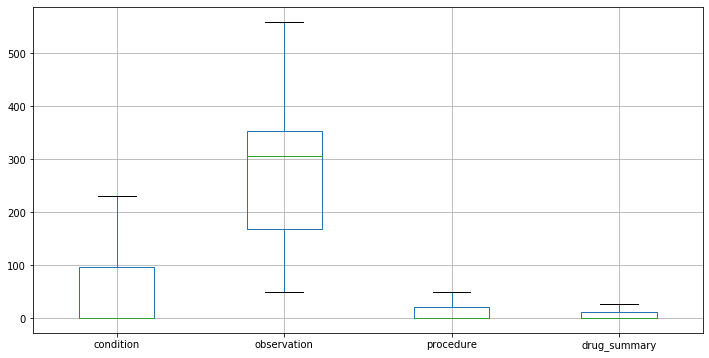

In [19]:
# Histogram showing counts for each OMOP data type, across the population. E.g., how many patients with 0 Conditions; 1-10; etc. (Ranges will be determined by the actual data distribution.)
omop_data_types_per_person = {data_type: [len(person[data_type+'.csv']) if data_type+'.csv' in person.keys() else 0 for person in omop_people.values()] for data_type in omop_data_types}
omop_df_types = pd.DataFrame(omop_data_types_per_person, index=omop_people.values())
omop_df_types.boxplot(figsize=(12,6), showfliers=False)

In [20]:
# Count of standardized code *systems* for each OMOP data type. E.g., fraction of SNOMED vs LOINC vs Other codes found in condition_concept_id.
systems = Counter()
for person, tables in omop_people.items():
    for filename, incidents in tables.items():
        for incident in incidents:
            systems[omop_concept_to_coding(incident, filename)[0][0]] += 1

systems

Counter({'SNOMED': 14183,
         'RxNorm': 1067,
         'CPT4': 1287,
         'PPI': 7353,
         'LOINC': 1660,
         'None': 9956,
         None: 202,
         'ICD9Proc': 97,
         'HCPCS': 23})

In [21]:
# Count of non-standardized code *systems* for each OMOP data type. E.g., fraction of SNOMED vs LOINC vs Other codes found in condition_source_concept_id

In [22]:
# Top N standardized codes for each data category. E.g., what were the top 10 Conditions?


In [23]:
# For each OMOP column, how often was a value present vs absent?
procedure_df = pd.DataFrame(omop_tables['procedure.csv'])
print("Number of rows: ", len(procedure_df))
procedure_columns = set(procedure_df.columns) - {
    'person_id',
    'procedure_date',
    'procedure_datetime',
    'procedure_occurrence_id'
}
for column in procedure_columns:
    print(procedure_df[column].value_counts()[:3])

Number of rows:  2020
2108115    154
2414398     85
2414397     69
Name: procedure_source_concept_id, dtype: int64
0           1337
44786630     683
Name: procedure_type_concept_id, dtype: int64
0    1582
      438
Name: provider_id, dtype: int64
         272
36415    154
99214     85
Name: procedure_source_value, dtype: int64
cpmc_ceders    1582
nec_phs         438
Name: src_hpo_id, dtype: int64
CPT4        1287
ICD9CM       225
ICD10PCS     202
Name: source_vocabulary, dtype: int64
4000000000181312    10
4000000000178509     9
4000000000173214     9
Name: visit_occurrence_id, dtype: int64
1    1582
      438
Name: quantity, dtype: int64
2108115    154
2414398     85
2414397     69
Name: procedure_concept_id, dtype: int64
            1439
0            438
42739576      53
Name: modifier_concept_id, dtype: int64
36415    154
99214     85
99213     69
Name: source_code_structured, dtype: int64
    2020
Name: qualifier_source_value, dtype: int64


In [24]:
print(
    "Number of found procedure_concept_ids in concept table: ",
    len(concept_df.loc[concept_df.index.isin(procedure_df['procedure_concept_id'])])
)
print(
    "Total number of procedure_concept_ids: ",
    len(procedure_df['procedure_concept_id'].value_counts())
)
missing_procedures = set(procedure_df['procedure_concept_id']) - set(concept_df.index.values) - set(cpt4_df.index.values)
missing_procedures

Number of found procedure_concept_ids in concept table:  93
Total number of procedure_concept_ids:  340


{'2724216',
 '2724519',
 '2724521',
 '2726351',
 '2738116',
 '2738416',
 '2741398',
 '2741878',
 '2746748',
 '2746758',
 '2746773',
 '2746793',
 '2746803',
 '2747311',
 '2750470',
 '2751060',
 '2751080',
 '2753383',
 '2756532',
 '2772731',
 '2774703',
 '2775232',
 '2778688',
 '2778894',
 '2780613',
 '2780645',
 '2784134',
 '2785970',
 '2785979',
 '2786175',
 '2786185',
 '2786222',
 '2786223',
 '2786229',
 '2786234',
 '2786472',
 '2786479',
 '2786484',
 '2792342',
 '2792981'}

In [25]:
observation_df = pd.DataFrame(omop_tables['observation.csv'])
print("Number of rows: ", len(observation_df))
observation_columns = set(observation_df.columns) - {
    'observation_id',
    'person_id',
    'observation_date',
    'observation_datetime',
}
for column in observation_columns:
    print(observation_df[column].value_counts()[:3])

Number of rows:  21472
rdr            18465
cpmc_ceders     2654
nec_phs          353
Name: src_hpo_id, dtype: int64
45905771    18452
38000280     3007
581413         13
Name: observation_type_concept_id, dtype: int64
    21472
Name: unit_source_value, dtype: int64
                    18452
4000000000118890        8
4000000000171298        8
Name: visit_occurrence_id, dtype: int64
bp_systolic     325
bp_diastolic    325
weight          317
Name: observation_source_value, dtype: int64
0          12106
1586155      139
1585636      129
Name: observation_source_concept_id, dtype: int64
0          9455
4041306    2654
1586155     139
Name: observation_concept_id, dtype: int64
No matching concept                   12106
White_WhiteSpecific                     139
RecreationalDrugUse_WhichDrugsUsed      129
Name: source_code_structured, dtype: int64
       9575
No     1876
Yes     911
Name: value_as_string, dtype: int64
    21472
Name: qualifier_source_value, dtype: int64
       20908
2.0  

In [26]:
print(
    "Number of found observation_concept_ids in concept table: ",
    len(concept_df.loc[concept_df.index.isin(observation_df['observation_concept_id'])])
)
print(
    "Total number of observation_concept_ids: ",
    len(observation_df['observation_concept_id'].value_counts())
)
missing_observations = set(observation_df['observation_concept_id']) - set(concept_df.index.values)

Number of found observation_concept_ids in concept table:  66
Total number of observation_concept_ids:  215


In [27]:
# For each OMOP column, how often was a value present vs absent?
condition_df = pd.DataFrame(omop_tables['condition.csv'])
print("Number of rows: ", len(condition_df))
condition_columns = set(condition_df.columns) - {
    'person_id',
    'condition_start_date',
    'condition_start_datetime',
    'condition_end_date',
    'condition_end_datetime',
    'condition_occurrence_id'
}
for column in condition_columns:
    print(condition_df[column].value_counts()[:3])

Number of rows:  11263
0    6545
     4718
Name: provider_id, dtype: int64
45556996    610
45552285    404
45600511    396
Name: condition_source_concept_id, dtype: int64
0           6180
4203942      365
44821787     144
Name: condition_status_concept_id, dtype: int64
cpmc_ceders    6545
nec_phs        4718
Name: src_hpo_id, dtype: int64
ICD10CM    7212
ICD9CM     4051
Name: source_vocabulary, dtype: int64
4000000000023113    45
4000000000027284    43
4000000000027356    43
Name: visit_occurrence_id, dtype: int64
C50.912    610
C79.51     404
C50.919    396
Name: condition_source_value, dtype: int64
      10898
AD      365
Name: condition_status_source_value, dtype: int64
0           4514
44786629    4284
44786627    2465
Name: condition_type_concept_id, dtype: int64
    11263
Name: stop_reason, dtype: int64
C50.912    610
C79.51     404
C50.919    396
Name: source_code_structured, dtype: int64
137809     872
4157332    506
0          495
Name: condition_concept_id, dtype: int64


In [28]:
print(
    "Number of found condition_concept_ids in concept table: ",
    len(concept_df.loc[concept_df.index.isin(condition_df['condition_concept_id'])])
)
print(
    "Total number of condition_concept_ids: ",
    len(condition_df['condition_concept_id'].value_counts())
)

Number of found condition_concept_ids in concept table:  775
Total number of condition_concept_ids:  775


In [29]:
##### Comparing OMOP to S4S #####
# Draw a distribution of "total # data elements in OMOP vs S4S" for each data category. E;g., each patient would contribute one dot to a Condition Count histogram by taking (# S4S Conditions - # OMOP conditions), which will be a positive number if more S4S conditions, and a negative number of more OMOP conditions.
# TODO (how to specify): show which values appeared in S4S but not OMOP, and vice versa.
# TODO: after early exploration, what else do we want to evaluate?

In [30]:
matched_people = {}
for person, tables in omop_people.items():
    matched_people[person] = {
        's4s': {},
        'omop': {},
    }
    #grab omop systems and codes
    for category, rows in tables.items():
        for row in rows:
            if category not in matched_people[person]['omop']:
                matched_people[person]['omop'][category] = Counter()
            coding_key = omop_concept_to_coding(row, category)
            matched_people[person]['omop'][category][coding_key] += 1
    #s4s systems and codes         
    for category, entries in s4s_people[person].items():
        for entry in entries:
            if entry['resourceType'] not in matched_people[person]['s4s']:
                matched_people[person]['s4s'][entry['resourceType']] = Counter()
            codings = fetch_at_path(entry, 'code.coding')
            if codings:
                coding_key = tuple((convert_vocabulary(coding['system']), coding['code']) for coding in codings)
                matched_people[person]['s4s'][entry['resourceType']][coding_key] += 1

http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
urn:oid:2.16.840.1.113883.6.90
urn:oid:2.16.840.1.113883.6.90
http://www.ama-assn.org/go/cpt
http://www.ama-assn.org/go/cpt
http://www.ama-assn.org/go/cpt
urn:oid:1.2.840.114350.1.13.202.2.7.2.696580
http://www.ama-assn.org/go/cpt
http://www.ama-assn.org/go/cpt
http://www.ama-assn.org/go/cpt
http://www.ama-assn.org/go/cpt
http://www.ama-assn.org/go/cpt
urn:oid:1.2.840.114350.1.13.202.2.7.2.696580
http://www.ama-assn.org/go/cpt
http://www.ama-assn.org/go/cpt
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
urn:oid:1.2.840.114350.1.13.202.2.7.2.696580
urn:oid:1.2.840.114350.1.13.202.2.7.2.696580
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http

http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
urn:oid:2.16.840.1.113883.6.90
urn:oid

urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://www.ama-assn.org/go/cpt
http://www.ama-assn.org/go/cpt
urn:oid:1.2.840.114350.1.13.362.2.7.2.696580
urn:oid:1.2.840.114350.1.13.362.2.7.2.696580
urn:oid:1.2.840.114350.1.13.362.2.7.2.696580
urn:oid:1.2.840.114350.1.13.362.2.7.2.696580
http://www.ama-assn.org/go/cpt
http://www.ama-assn.org/go/cpt
http://www.ama-assn.org/go/cpt
http://www.ama-assn.org/go/cpt
http://www.ama-assn.org/go/cpt
urn:oid:1.2.840.114350.1.13.362.2.7.2.696580
urn:oid:1.2.840.114350.1.13.362.2.7.2.696580
urn:oid:1.2.840.114350.1.13.362.2.7.2.696580
urn:oid:1.2.840.114350.1.13.362.2.7.2.696580
http://www.ama-assn.org/go/cpt
http://www.ama-assn.org/go/cpt
http://www.ama-assn.org/go/cpt
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
htt

http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
urn:oid:2.16.840.1.113883.6.90
http://

urn:oid:1.2.840.114350.1.13.71.2.7.2.696580
http://www.ama-assn.org/go/cpt
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diagnosis
urn:oid:2.16.840.1.113883.6.90
http://hl7.org/fhir/sid/icd-9-cm/diag

In [31]:
unique_observations = {}
from itertools import chain
for person, datasets in matched_people.items():
    s4s_codable_concepts = datasets['s4s']['Observation'].keys()
    omop_codable_concepts = datasets['omop']['observation.csv'].keys()
    s4s_codes = set([v for v in chain(*s4s_codable_concepts)])
    omop_codes = set([v for v in chain(*omop_codable_concepts)])
    s4s_split = split_codable_concepts(s4s_codable_concepts, omop_codes)
    omop_split = split_codable_concepts(omop_codable_concepts, s4s_codes)
    unique_observations[person] = {
        's4s_total': sum(datasets['s4s']['Observation'].values()),
        's4s_unique': len(datasets['s4s']['Observation']),
        'omop_total': sum(datasets['omop']['observation.csv'].values()),
        'omop_unique': len(datasets['omop']['observation.csv']),
        'S4S_CC_matched': len(s4s_split['matched']),
        'S4S_CC_unmatched': len(s4s_split['unmatched']),
        'OMOP_CC_matched': len(omop_split['matched']),
        'OMOP_CC_unmatched': len(omop_split['unmatched']),
    }
    print(s4s_codes.intersection(omop_codes))
unique_observation_df = pd.DataFrame(unique_observations).transpose()
unique_observation_df.reset_index(inplace=True)
unique_observation_df.drop(columns='index', inplace=True)
pd.options.display.max_rows = 100
unique_observation_df

set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()


,OMOP_CC_matched,OMOP_CC_unmatched,S4S_CC_matched,S4S_CC_unmatched,omop_total,omop_unique,s4s_total,s4s_unique
0,0,109,0,12,131,109,49,12
1,0,118,0,50,197,118,60,50
2,0,126,0,66,357,126,267,66
3,0,127,0,64,308,127,154,64
4,0,125,0,17,304,125,74,17
5,0,119,0,61,299,119,928,61
6,0,124,0,139,361,124,2138,139
7,0,109,0,134,675,109,1062,134
8,0,124,0,73,303,124,621,73
9,0,123,0,54,164,123,465,54


In [32]:
#sanity check
(1,2) in {(1,2), (3,4)}

True

In [33]:
missing_concept_codes

{'2724216',
 '2724519',
 '2724521',
 '2726351',
 '2738116',
 '2738416',
 '2741398',
 '2741878',
 '2746748',
 '2746758',
 '2746773',
 '2746793',
 '2746803',
 '2747311',
 '2750470',
 '2751060',
 '2751080',
 '2753383',
 '2756532',
 '2772731',
 '2774703',
 '2775232',
 '2778688',
 '2778894',
 '2780613',
 '2780645',
 '2784134',
 '2785970',
 '2785979',
 '2786175',
 '2786185',
 '2786222',
 '2786223',
 '2786229',
 '2786234',
 '2786472',
 '2786479',
 '2786484',
 '2792342',
 '2792981'}

In [35]:
split_codable_concepts([(('http://loinc.org', '4'),)], {('LOINC', '4')})

{'matched': set(), 'unmatched': {(('http://loinc.org', '4'),)}}